# Project Description
In this project I have some non linear data where there are two clusters/categories that I want to classify. I will do this by testing different classification algorithms (logistic regression, k nearest neighbors, desicion trees and random forests) and testing out which one gives the best results. I will go over the basics of what each algorithm does. We will analyze the score of each algorithm and see what it means or if its any good. 


In this project I will attempt to find the best performing machine learning classification algorithm to solve a problem. The problem in this project is we have some non linear data where we have two clusters or segments that are overlapping. We want to try and see which classification algorithm will best solve this issue. What I will do in this project is load my data in. Graph the data so we can see what it looks like and if it can give us insights onto how to solve the problem. I'll then use multiple classification algorithms to see which one performes best and gives the best accuracy. 

# Imports

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Loading Data

In [42]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [43]:
X_train

,col1,col2
0,0.283087,-0.197163
1,0.986381,0.164478
2,-0.952769,0.303694
3,1.979364,0.297895
4,1.399762,-0.416619
...,...,...
599995,0.980339,0.197321
599996,0.570858,0.821049
599997,-0.518881,0.854846
599998,0.185451,-0.080095


# Graphing the Data
By graphing the data we can see what type of data were dealing with (linear/non linear). This is helpful to see what approach we can take or what it is the problem were solving. For example from graphing the data we can see that this is non linear data. We can also see that there are two clusters/groups that we can probably draw some boundary to seperate and classify. This of course is our task which is to see which classification algorithm can best 

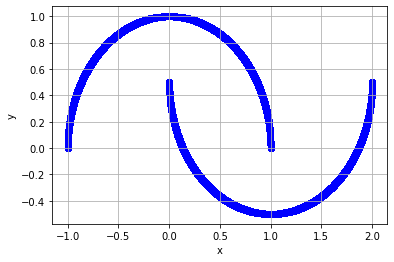

In [44]:
%matplotlib inline 
plt.scatter(X_train['col1'], X_train['col2'], color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show();

In [45]:
# reformat data to numpy array so we can use it more easily
y_train = y_train['outputs'].to_numpy()

In [46]:
def graph_boundary(model):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="auto")
    plt.scatter(X_train['col1'], X_train['col2'], color='b')
    plt.xlim([-1.5, 2.5])
    plt.ylim([-.7, 1.1])
    plt.show()

# Using Logistic Regression
The first algorithm I am going to try is logistic regression.

In [47]:
# import model
from sklearn.linear_model import LogisticRegression 

In [48]:
# create the model 
logistic_regression = LogisticRegression()

In [49]:
 # train model on the training data
logistic_regression = logistic_regression.fit(X_train, y_train)

Here we can clearly see that the model is underfitting the data. When a model underfits the data both the training score and test score are bad. This means that logistic regression is not going to be a good algorithm to solve this classfication problem. 

In [50]:
# get train accuracy
logistic_regression.score(X_train, y_train)

0.8937433333333333

In [51]:
# get test accuracy
logistic_regression.score(X_test, y_test)

0.894175

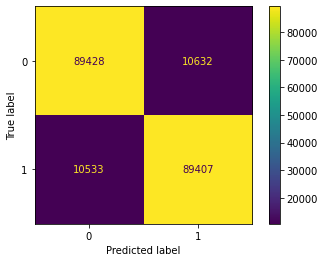

In [52]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logistic_regression, X_test, y_test)  
plt.show() 

To see further into what exactly the model is doing here is a graph of the desicion boundary. The desicion boundary is the boundary that shows how our model is classifying data. For example here is the graph of the desicion boundary for logistic regression for our problem. As we can see there is a line running through both categories/clusters. That line is what the model uses to ceperate and predict categories. Meaning if a new example is in the blue section or below the line it will belong to that class. We can see that the model gets the majority of the data correctly but fails in the middle.  

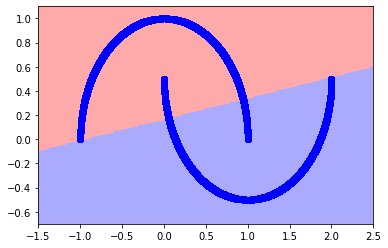

In [53]:
graph_boundary(logistic_regression)

# Using KNN
Now we will be using another classification algorithm which is knn (k nearest neighbors). The way this algorithm works is that we want to classify something we find some odd number `k`. This odd number is how many near by examples we will check. For example if our `k=3` we will check for the three closests neighbors of our example we are trying to classify. The majority catergory in those three neighbors is what the algorithm predicts. One thing to note is that we check how close the neighbors are by taking the distance from one example to our example. A common distance is the Euclidean distance where d=sqrt((x-a)^2+(y-b)^2). This is how we find what is closest to our example we are trying to classify. Here is a visual example

In [54]:
# import model
from sklearn.neighbors import KNeighborsClassifier

A big part of `k nearest neighbors` is the hyperparameter `k`. Here we have our `k` equal to seven. As mentioned earlier this is the number of neighbors the algorithm will check to make a prediction. There are many ways we can choose our `k` one way is just trying manually a bunch of different values and checking what gives us a better outcomes. This of course can work but is not a good solution. Another way is making some desicions on what would be a good value. For example I knew the number needed to be odd and I knew that a if a choose a small odd number like three I could possbily risk overfitting. Here is an example using a number I thought would be a good fit. 

In [55]:
# create model with 7 neighbors to define
manual_knn = KNeighborsClassifier(n_neighbors=7)

In [56]:
# train the model
manual_knn = manual_knn.fit(X_train, y_train)

In [57]:
# get training accuracy
manual_knn.fit(X_train, y_train).score(X_train, y_train) 

1.0

In [58]:
# get test accuracy
manual_knn.score(X_test, y_test) 

1.0

The desicion boundary here is very different compared to the logistic regression one. 

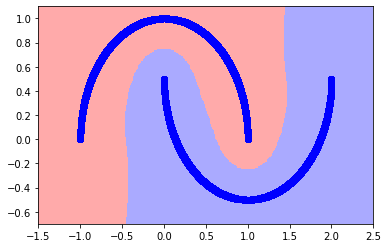

In [59]:
graph_boundary(manual_knn)

Another way of getting a hyperparameter is using hyperparameter optimization which is using machine learning to learn which parameters are best for our algorithm. An example of this is [linear regression with graident desecent](https://github.com/GaelGil/notebooks/blob/master/linear_regression/gradient_descent.ipynb). In gradient descent we take the gradient of the sum of the squared errors to find the best parameters for our algorithm. Here is an example of knn using hyper parameter optimization. 

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
clf = GridSearchCV(KNeighborsClassifier(),{
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}, return_train_score=False)

In [62]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [63]:
df = pd.DataFrame(clf.cv_results_)

As we can see any parameter would be good for this problem. We know these are all good because all these parameters give back the same mean test score. This of course makes sense because if we take a look at the data all the examples in each category are so close to each other. 

In [64]:
df[['param_n_neighbors', 'mean_test_score']]

,param_n_neighbors,mean_test_score
0,1,1.0
1,3,1.0
2,5,1.0
3,7,1.0
4,9,1.0
5,11,1.0


# Using Desicion Trees
Another great classification algorithm is desicion trees. The way this model works is the model takes in some data. The model then takes each example split them all into binary catergories. It stops until there are no more catergories we can split the examples into. To simplify it the model creates a bunch of if statements that each example has . When we want to classify a new example we just put the example through our tree and it gets fit into one of these statements until it cant go further. 

In [65]:
 # import model
from sklearn import tree

In [66]:
tree_clf = tree.DecisionTreeClassifier()

In [67]:
tree_clf = tree_clf.fit(X_train, y_train)

In [68]:
tree_clf.score(X_train, y_train)

1.0

In [69]:
tree_clf.score(X_test, y_test)

0.99996

As we can see the desicion boundary here has no curves its just straight lines. This makes sense of course because we as explained earlier our algorithm breaks down everything into binary categories meaning it can go one way or the other and theres no in between. We can also see a small blue line at around y=0.5. This could possibly mean that there is some overfitting. Overall desicion trees was a good algorithm to solve this problem. 

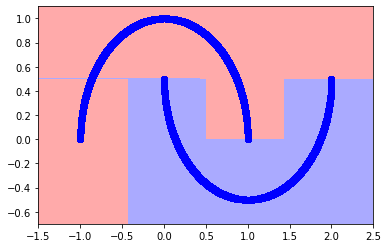

In [70]:
graph_boundary(tree_clf)

# Using Random Forests